# import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from torchsummary import summary

import time
import os
os.environ['KMB_DUBLICATE_LIB_OK']='true'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_21688\2074352296.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# create data and prepare loaders

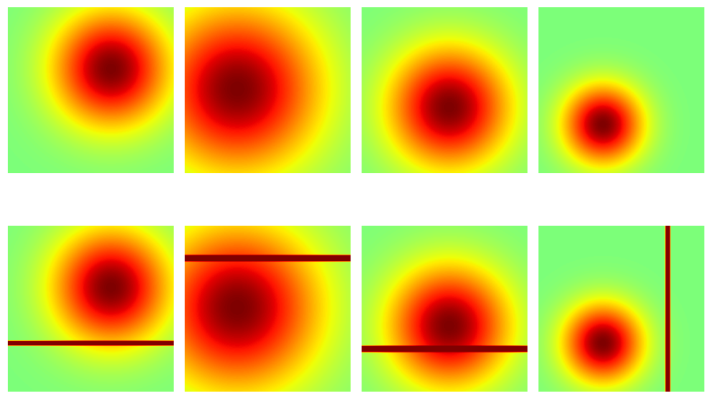

In [2]:
numGauss=2000
imgsize=101

x=np.linspace(-4,4,imgsize)
X,Y=np.meshgrid(x,x)

widths=np.linspace(2,20,numGauss)
images=torch.zeros(numGauss,1,imgsize,imgsize)
Occ_images=torch.zeros(numGauss,1,imgsize,imgsize)

for i in range(numGauss):
    ro=1.5*np.random.randn(2)
    Gaus=np.exp( -((X-ro[0])**2 + (Y-ro[1])**2) / widths[i])
    
#     Gaus=Gaus+np.random.randn(imgsize,imgsize) / 5
    
    images[i,:,:,:]=torch.Tensor(Gaus).view(1,imgsize,imgsize)
    
    i1 = np.random.choice(np.arange(10,imgsize-10))
    i2 = np.random.choice(np.arange(2,6))
    if np.random.randn()>0:
        Gaus[i1:i1+i2,] = 1
    else:
        Gaus[:,i1:i1+i2] = 1
    
    Occ_images[i,:,:,:]=torch.Tensor(Gaus).view(1,imgsize,imgsize)
    
# some images show
fig,ax=plt.subplots(2,4,figsize=(10,7))

for i in range(4):
    pixel=np.random.randint(images.shape[0])
    ax[0,i].imshow(torch.squeeze(images[pixel,:,:,:]),vmin=-1,vmax=1,cmap='jet')
    ax[1,i].imshow(torch.squeeze(Occ_images[pixel,:,:,:]),vmin=-1,vmax=1,cmap='jet')
    
    ax[0,i].set_xticks([])
    ax[1,i].set_yticks([])
    
    for c in range(2): ax[c,i].axis('off') 
    
plt.tight_layout()
plt.show()

In [3]:
train_data,devtest_data,train_dataOcc,devtest_dataOcc=train_test_split(
                                        images,Occ_images,train_size=.9)

test_data,dev_data,test_dataOcc,dev_dataOcc=train_test_split(devtest_data,
                                        devtest_dataOcc,train_size=.9)

train_dataset=TensorDataset(train_data,train_dataOcc)
dev_dataset=TensorDataset(dev_data,dev_dataOcc)
test_dataset=TensorDataset(test_data,test_dataOcc)

#create data loaders
train_loader_set=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)

dev_loader_set=DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])

test_loader_set=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


print(f'train_loader_set shape{train_loader_set.dataset.tensors[0].shape}')
print(f'dev_loader_set shape {dev_loader_set.dataset.tensors[0].shape}')
print(f'test_loader_set shape {test_loader_set.dataset.tensors[0].shape}')

train_loader_set shapetorch.Size([1800, 1, 101, 101])
dev_loader_set shape torch.Size([20, 1, 101, 101])
test_loader_set shape torch.Size([180, 1, 101, 101])


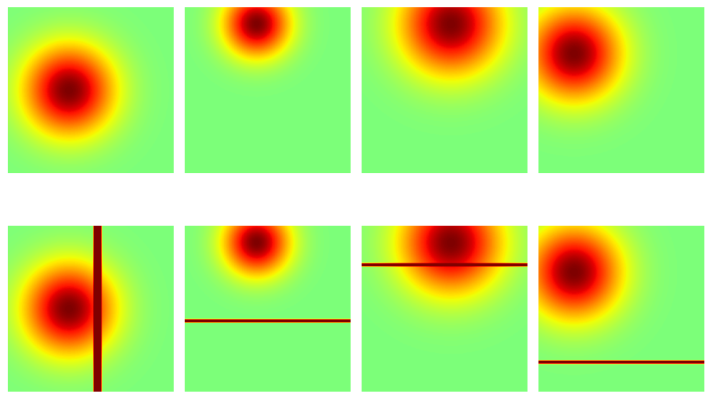

In [4]:
fig,ax=plt.subplots(2,4,figsize=(10,7))

for i in range(4):
    pixel=np.random.randint(train_loader_set.dataset.tensors[0].shape[0])
    ax[0,i].imshow(torch.squeeze(train_loader_set.dataset.tensors[0][pixel,:,:,:]).detach(),\
                   vmin=-1,vmax=1,cmap='jet')
    ax[1,i].imshow(torch.squeeze(train_loader_set.dataset.tensors[1][pixel,:,:,:]).detach(),\
                   vmin=-1,vmax=1,cmap='jet')
    
    ax[0,i].set_xticks([])
    ax[1,i].set_yticks([])
    
    for c in range(2): ax[c,i].axis('off') 
    
plt.tight_layout()
plt.show()

# cnn autoencoder

In [5]:
def createModel():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc=nn.Sequential(
                #layer1
                nn.Conv2d(1,6,3,1,1),
                nn.ReLU(),
                nn.MaxPool2d(3,2,0),
                #layer2
                nn.Conv2d(6,4,3,1,1),
                nn.ReLU(),
                nn.MaxPool2d(3,2,1)           
            )
            
            self.dec=nn.Sequential(
                #layer3
                nn.ConvTranspose2d(4,6,3,2,1),
                nn.ReLU(),
                #layer4
                nn.ConvTranspose2d(6,1,7,2,1)           
            )
        def forward(self,x):
            x=self.enc(x)
            x=self.dec(x)
            return x
    
    cnnAU=Model()
    lossfun=nn.MSELoss()
    optimizer=torch.optim.Adam(cnnAU.parameters(),lr=.001)
    return cnnAU,lossfun,optimizer

torch.Size([180, 1, 101, 101])


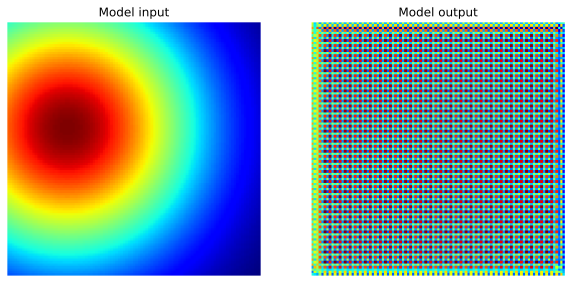

In [6]:
cnn=createModel()[0]
dat,lab=next(iter(test_loader_set))

yHat=cnn(dat)
print(yHat.shape)

fig,ax=plt.subplots(1,2,figsize=(10,7))
ax[0].imshow(torch.squeeze(dat[10,:,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[10,:,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')
for i in range(2):ax[i].axis('off')
plt.show()

In [7]:
summary(cnn,(1,imgsize,imgsize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 25, 25]           --
|    └─Conv2d: 2-1                       [-1, 6, 101, 101]         60
|    └─ReLU: 2-2                         [-1, 6, 101, 101]         --
|    └─MaxPool2d: 2-3                    [-1, 6, 50, 50]           --
|    └─Conv2d: 2-4                       [-1, 4, 50, 50]           220
|    └─ReLU: 2-5                         [-1, 4, 50, 50]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 25, 25]           --
├─Sequential: 1-2                        [-1, 1, 101, 101]         --
|    └─ConvTranspose2d: 2-7              [-1, 6, 49, 49]           222
|    └─ReLU: 2-8                         [-1, 6, 49, 49]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 101, 101]         295
Total params: 797
Trainable params: 797
Non-trainable params: 0
Total mult-adds (M): 4.61
Input size (MB): 0.04
Forward/backward pass size (MB): 0.73
Pa

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 25, 25]           --
|    └─Conv2d: 2-1                       [-1, 6, 101, 101]         60
|    └─ReLU: 2-2                         [-1, 6, 101, 101]         --
|    └─MaxPool2d: 2-3                    [-1, 6, 50, 50]           --
|    └─Conv2d: 2-4                       [-1, 4, 50, 50]           220
|    └─ReLU: 2-5                         [-1, 4, 50, 50]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 25, 25]           --
├─Sequential: 1-2                        [-1, 1, 101, 101]         --
|    └─ConvTranspose2d: 2-7              [-1, 6, 49, 49]           222
|    └─ReLU: 2-8                         [-1, 6, 49, 49]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 101, 101]         295
Total params: 797
Trainable params: 797
Non-trainable params: 0
Total mult-adds (M): 4.61
Input size (MB): 0.04
Forward/backward pass size (MB): 0.73
Pa

# Model Training

In [8]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
def trainModel(Numepoch=10):
    Train_losses=torch.zeros(Numepoch)
    devol_losses=torch.zeros(Numepoch)
    
    cnnAU,lossfun,optimizer=createModel()
    cnnAU.to(device)
    
    for epoch in range(Numepoch):
        batchLoss=[]
        cnnAU.train()
        for dat,datOcc in train_loader_set:
            dat=dat.to(device)
            datOcc=datOcc.to(device)
            
            yHat=cnnAU(datOcc)
            loss=lossfun(yHat,dat)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
        
        Train_losses[epoch]=np.mean(batchLoss)
        
        cnnAU.eval()
        dat,datOcc = next(iter(dev_loader_set))
        dat=dat.to(device)
        datOcc=datOcc.to(device)
        
        if torch.no_grad():
            yHat=cnnAU(datOcc)
            loss=lossfun(yHat,dat)
            devol_losses[epoch]=loss.item()
        
    cnnAU.cpu()
    return cnnAU,Train_losses,devol_losses     

Text(0.5, 1.0, 'devolped loss: 0.0019')

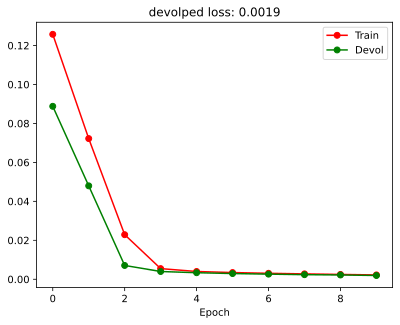

In [10]:
cnnAU,Train_losses,devol_losses=trainModel()
plt.plot(Train_losses,'ro-',label='Train')
plt.plot(devol_losses,'go-',label='Devol')
plt.legend()
plt.xlabel('Epoch')
plt.title(f'devolped loss: {devol_losses[-1]:.4f}')

# model testing

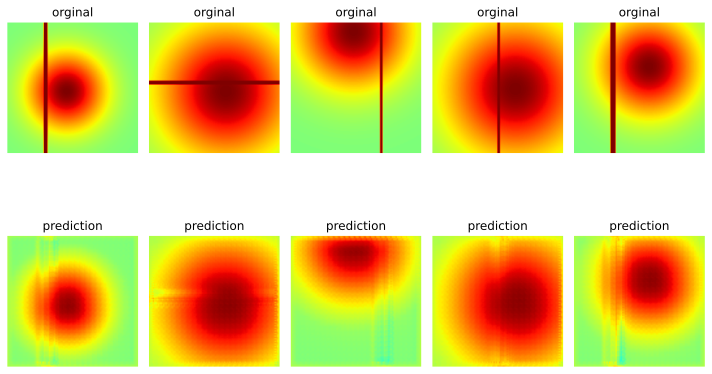

In [11]:
dat,datOcc=next(iter(test_loader_set))
prediction=cnnAU(datOcc)

fig,ax=plt.subplots(2,5,figsize=(10,7))
for i in range(5):
    index=np.random.randint(dat.shape[0])
    ax[0,i].imshow(torch.squeeze(datOcc[index,:,:,:]).detach(),cmap='jet',vmin=-1,vmax=1)
    ax[0,i].set_title('orginal')
    
    ax[1,i].imshow(torch.squeeze(prediction[index,:,:,:]).detach(),cmap='jet',vmin=-1,vmax=1)
    ax[1,i].set_title('prediction')
    
    for c in range(2):ax[c,i].axis('off')
        
plt.tight_layout()
plt.show()